# Results Visualizations for Workshop Paper (EPIG vs EPIG-BALD vs BALD)
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = load_laaos_files("./results/icml_workshop_epig_vs_epig_bald_vs_bald_noise")

In [ ]:
get_any(results).config

_config(seed=806, acquisition_size=5, max_training_set=300, num_pool_samples=100, num_validation_samples=20, num_training_samples=1, num_patience_epochs=20, max_training_epochs=120, training_batch_size=64, device='cuda', validation_set_size=2048, initial_set_size=20, min_samples_per_epoch=1024, repeated_mnist_repetitions=2, add_dataset_noise=True, acquisition_function='batchbald_redux.acquisition_functions.BatchBALD', train_eval_model='batchbald_redux.train_eval_model.TrainSelfDistillationEvalModel', model_optimizer_factory='batchbald_redux.models.MnistOptimizerFactory', acquisition_function_args=None, temperature=0.0)

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,15,1622948931
1,12,1622946610
2,7,1622940566
3,23,1622957759
4,5,1622936485
5,20,1622953486
6,28,1622959404
7,16,1622949539
8,21,1622954452
9,29,1622959912


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

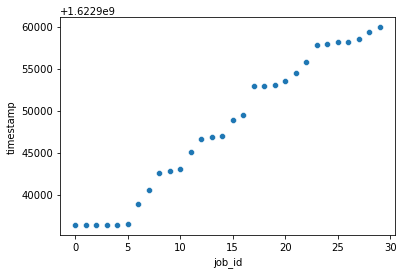

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(30, 30)

```
configs = [
            Experiment(
                seed=seed,
                acquisition_function=AcquisitionFunction.bald,
                acquisition_size=acquisition_size,
                num_pool_samples=num_pool_samples,
            )
            for seed in range(5)
            for acquisition_size in [5, 10, 20, 50]
            for num_pool_samples in [10, 20, 50, 100]
        ] + [
            Experiment(
                seed=seed,
                acquisition_function=AcquisitionFunction.random,
                acquisition_size=5,
                num_pool_samples=20,
            )
            for seed in range(20)
        ]
```

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue
        
    config = result.config

    acquisition_size = config.acquisition_size
    acquisition_function = config.acquisition_function[len("batchbald_redux.acquisition_functions.") :]
    num_pool_samples = config.num_pool_samples
    repeated_mnist_repetitions= config.repeated_mnist_repetitions
    
    seed = config.seed

    if acquisition_function == "random":
        acquisition_sizes = [5]
    else:
        acquisition_sizes = [acquisition_size]
        
    if acquisition_function == "random":
        num_pool_samples = [100]
    else:
        num_pool_samples = [num_pool_samples]
        
    if repeated_mnist_repetitions == 1:
        dataset = "MNIST"
    else:
        dataset = f"MNISTx{repeated_mnist_repetitions}"
        
    for nps in num_pool_samples:
        for acquisition_size in acquisition_sizes:
            initial_set_size = len(result.initial_training_set_indices)

            if (
                initial_set_size
                + sum(1 if hasattr(step, "evaluation_metrics") else 0 for step in result.active_learning_steps)
                * config.acquisition_size
                < 30
            ):
                print(len(result.active_learning_steps), file)
                continue

            for i, step in enumerate(result.active_learning_steps):
                if not hasattr(step, "evaluation_metrics"):
                    break
                training_set_size = initial_set_size + i * config.acquisition_size
                accuracy = step.evaluation_metrics.accuracy

                experiment_data.append(
                    dict(
                        dataset=dataset,
                        acquisition_function=acquisition_function,
                        acquisition_size=acquisition_size,
                        num_pool_samples=nps,
                        training_set_size=training_set_size,
                        accuracy=accuracy,
                        seed=seed,
                    )
                )

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,dataset,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed
0,MNISTx2,BatchBALD,5,100,20,0.6531,806
1,MNISTx2,BatchBALD,5,100,25,0.7338,806
2,MNISTx2,BatchBALD,5,100,30,0.7455,806
3,MNISTx2,BatchBALD,5,100,35,0.7370,806
4,MNISTx2,BatchBALD,5,100,40,0.7570,806
...,...,...,...,...,...,...,...
1705,MNISTx2,EvalBALD,5,100,280,0.9353,819
1706,MNISTx2,EvalBALD,5,100,285,0.9436,819
1707,MNISTx2,EvalBALD,5,100,290,0.9490,819
1708,MNISTx2,EvalBALD,5,100,295,0.9469,819


In [ ]:
df.acquisition_function.unique()

array(['BatchBALD', 'EIG', 'BALD', 'BatchEIG', 'EvalBALD',
       'BatchEvalBALD'], dtype=object)

In [ ]:
nice_acquisition_function_map = {
    'BatchEIG': "Batch EPIG",
    'EvalBALD': "EPIG-BALD",
    'BatchBALD': "Batch BALD",
    'EIG': "EPIG",
    'BALD': "BALD",
    'BatchEvalBALD': "Batch EPIG-BALD"
}


def to_nice_acquisition_function(n):
    return nice_acquisition_function_map[n]

In [ ]:
df["nice_acquisition_function"] = df.acquisition_function.map(nice_acquisition_function_map)

In [ ]:
df.acquisition_size.unique()

array([5])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("training_set_size == 20").groupby(["acquisition_size", "dataset"])["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

acquisition_size  dataset  acquisition_function
5                 MNISTx2  BALD                    5
                           BatchBALD               5
                           BatchEIG                5
                           BatchEvalBALD           5
                           EIG                     5
                           EvalBALD                5
Name: num_trials, dtype: int64


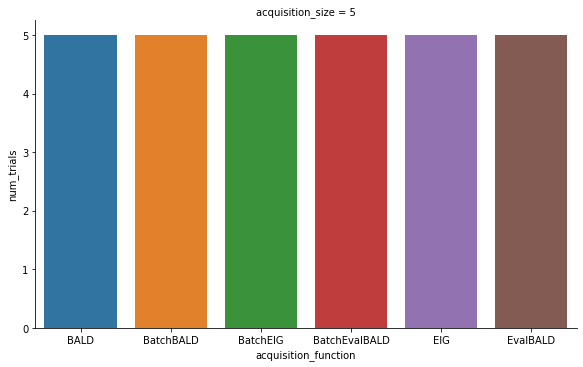

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x="acquisition_function",
    col="acquisition_size",
    aspect=1.6,
)
grd.fig.patch.set_alpha(1)

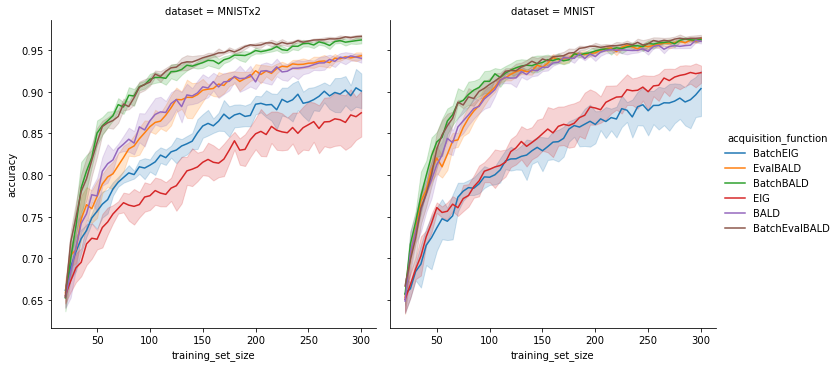

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="dataset",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

grd.fig.patch.set_alpha(1)

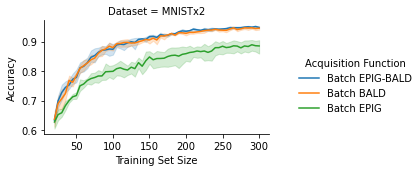

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="dataset",
    hue="nice_acquisition_function",
    data=df[df["acquisition_function"].isin(["BatchEIG", "BatchBALD", "BatchEvalBALD"])],
    kind="line",
    hue_order = list(
        map(
            to_nice_acquisition_function,
            [
                "BatchEvalBALD", "BatchBALD", "BatchEIG",
            ],
        )
    ),
    height=2.5,
    aspect=1.6
)

grd.fig.patch.set_alpha(1)
grd.set_xlabels("Training Set Size")
grd.set_ylabels("Accuracy")
grd._legend.set_title("Acquisition Function")
grd.set_titles("Dataset = {col_name}")
grd.tight_layout()

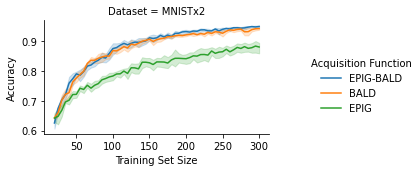

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="dataset",
    hue="nice_acquisition_function",
    data=df[df["acquisition_function"].isin(["EIG", "BALD", "EvalBALD"])],
    kind="line",
    hue_order = list(
        map(
            to_nice_acquisition_function,
            [
                "EvalBALD", "BALD", "EIG",
            ],
        )
    ),
    height=2.5,
    aspect=1.6
)

grd.fig.patch.set_alpha(1)
grd.set_xlabels("Training Set Size")
grd.set_ylabels("Accuracy")
grd._legend.set_title("Acquisition Function")
grd.set_titles("Dataset = {col_name}")
grd.tight_layout()

In [ ]:
import qgrid

df.sort_values("training_set_size", ascending=True, inplace=True)

df["max_accuracy"] = df.groupby(["seed", "dataset", "acquisition_size", "acquisition_function", "num_pool_samples"]).accuracy.cummax()

df_max_accuracy = df.drop_duplicates(subset=["seed", "dataset", "acquisition_size", "acquisition_function", "num_pool_samples", "max_accuracy"])
df_max_accuracy

,dataset,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed,nice_acquisition_function,max_accuracy
0,MNISTx2,BatchBALD,5,100,20,0.6531,806,Batch BALD,0.6531
1596,MNISTx2,BatchEvalBALD,5,100,20,0.6396,793,Batch EPIG-BALD,0.6396
114,MNISTx2,BALD,5,100,20,0.6572,797,BALD,0.6572
1539,MNISTx2,EIG,5,100,20,0.6381,796,EPIG,0.6381
171,MNISTx2,BatchEIG,5,100,20,0.6366,815,Batch EPIG,0.6366
...,...,...,...,...,...,...,...,...,...
910,MNISTx2,BALD,5,100,295,0.9511,818,BALD,0.9511
113,MNISTx2,EIG,5,100,300,0.8937,803,EPIG,0.8937
170,MNISTx2,BALD,5,100,300,0.9407,797,BALD,0.9407
1139,MNISTx2,BatchBALD,5,100,300,0.9517,799,Batch BALD,0.9517


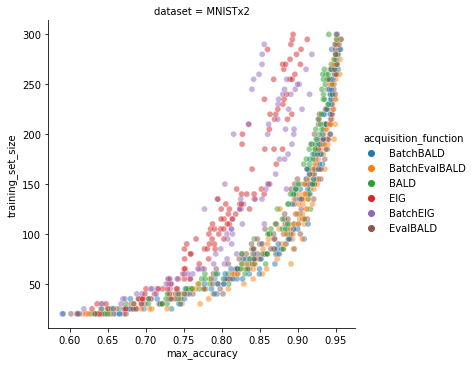

In [ ]:
grd = sns.relplot(
    y="training_set_size",
    x="max_accuracy",
    col="dataset",
    hue="acquisition_function",
    data=df_max_accuracy,
    kind="scatter",
    height=5,
    alpha=0.5,
)

grd.fig.patch.set_alpha(1)

In [ ]:
df2 = df[(df.accuracy >= 0.90) & (df.acquisition_function != "random")].groupby(["seed", "acquisition_size", "acquisition_function", "dataset"]).first()

In [ ]:
df3 = df2.groupby(["dataset", "acquisition_function", "num_pool_samples"]).training_set_size.quantile([0.25, 0.5, 0.75])

In [ ]:
df3.unstack()

0.25   0.50   0.75
dataset acquisition_function num_pool_samples                     
MNISTx2 BALD                 100               125.0  145.0  150.0
        BatchBALD            100               110.0  120.0  145.0
        BatchEIG             100               237.5  250.0  257.5
        BatchEvalBALD        100               110.0  125.0  130.0
        EIG                  100               270.0  270.0  270.0
        EvalBALD             100               115.0  125.0  135.0

## 95% accuracy on MNIST:
    
|acquisition_function |num_pool_samples | 0.25 | 0.50 | 0.75  |
|---------------------|-----------------|------|------|-------|
|BatchEvalBALD        |100              | 180.0| 185.0| 190.0 |
|BatchBALD            |100              | 205.0| 205.0| 210.0 |
|EvalBALD             |100              | 205.0| 205.0| 210.0 |
|BALD                 |100              | 205.0| 210.0| 215.0 |


In [ ]:
df3.unstack()

0.25   0.50   0.75
dataset acquisition_function num_pool_samples                     
MNIST   BALD                 100               205.0  210.0  215.0
        BatchBALD            100               205.0  205.0  210.0
        BatchEvalBALD        100               180.0  185.0  190.0
        EvalBALD             100               205.0  205.0  210.0
MNISTx2 BatchBALD            100               190.0  200.0  210.0
        BatchEvalBALD        100               175.0  185.0  190.0
        EvalBALD             100               295.0  295.0  295.0